# Anisotropy constraints with IFU data
This notebook assesses constraining power of IFU radial data to constrain the anisotropy distribution.

Author: Simon Birrer

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# import lenstronomy modules
from lenstronomy.GalKin.galkin import Galkin

from pylab import rc

rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

# compute angular diameter distances in the lensing system
d_d = cosmo.angular_diameter_distance(z_lens).value
d_s = cosmo.angular_diameter_distance(z_source).value
d_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source).value
kwargs_cosmo = {'d_d': d_d, 'd_s': d_s, 'd_ds': d_ds}


# set up for lens and light model
lens_model_list = ['SPP', 'CORED_DENSITY_2']
light_model_list = ['HERNQUIST']

# observational conditions of the spectroscopic campagne

psf_fwhm = 1.
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

r_bins = np.linspace(0, 2, 10)
r_list = (r_bins[1:] + r_bins[:-1]) / 2
delta_r = r_bins[1] - r_bins[0]
kwargs_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins,  'center_ra': 0, 'center_dec': 0}

kwargs_galkin_numerics = {
                          'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals



In [3]:
# default model settings

r_ani = 1.
kwargs_anisotropy = {'r_ani': r_ani}

r_eff = 1.
kwargs_light = [{'Rs': 0.551 * r_eff, 'amp': 1}]

gamma = 2
theta_E = 1.5
kwargs_core = {'sigma0': 0.0, 'r_core': 10, 'center_x': 0, 'center_y': 0}
kwargs_mass = [{'theta_E': theta_E, 'gamma': gamma, 'center_x': 0, 'center_y': 0}, kwargs_core]



In [5]:
# r_ani dependence with OsipkovMerritt model
anisotropy_model = 'OM'
kwargs_model = {'anisotropy_model': anisotropy_model,
               'mass_profile_list': lens_model_list,
               'light_profile_list': light_model_list}

galkin = Galkin(kwargs_model, kwargs_aperture, kwargs_psf, kwargs_cosmo, kwargs_numerics=kwargs_galkin_numerics,
                 analytic_kinematics=False)



a_ani_list = np.array([0.5, 1, 2, 5])

# half-light radius dependence
r_eff_list = np.array([0.5, 1., 2.])

# power-law dependence
gamma_list = np.array([1.9, 2, 2.1])
sigma_v_om = []

for k, gamma in enumerate(gamma_list):
    sigma_v_r_eff = []
    kwargs_mass = [{'theta_E': theta_E, 'gamma': gamma}, kwargs_core]
    for j, r_eff in enumerate(r_eff_list):
        sigma_v_r_ani_list = []
        kwargs_light = [{'Rs': 0.551 * r_eff, 'amp': 1}]
        #kwargs_light = {'r_eff': r_eff}

        for i, a_ani in enumerate(a_ani_list):
            kwargs_anisotropy = {'r_ani': a_ani * r_eff}
            sigma_v_ifu = galkin.dispersion_map(kwargs_mass, kwargs_light, kwargs_anisotropy, num_kin_sampling=1000, num_psf_sampling=100)
            sigma_v_r_ani_list.append(sigma_v_ifu)
        sigma_v_r_eff.append(sigma_v_r_ani_list)
    sigma_v_om.append(sigma_v_r_eff)



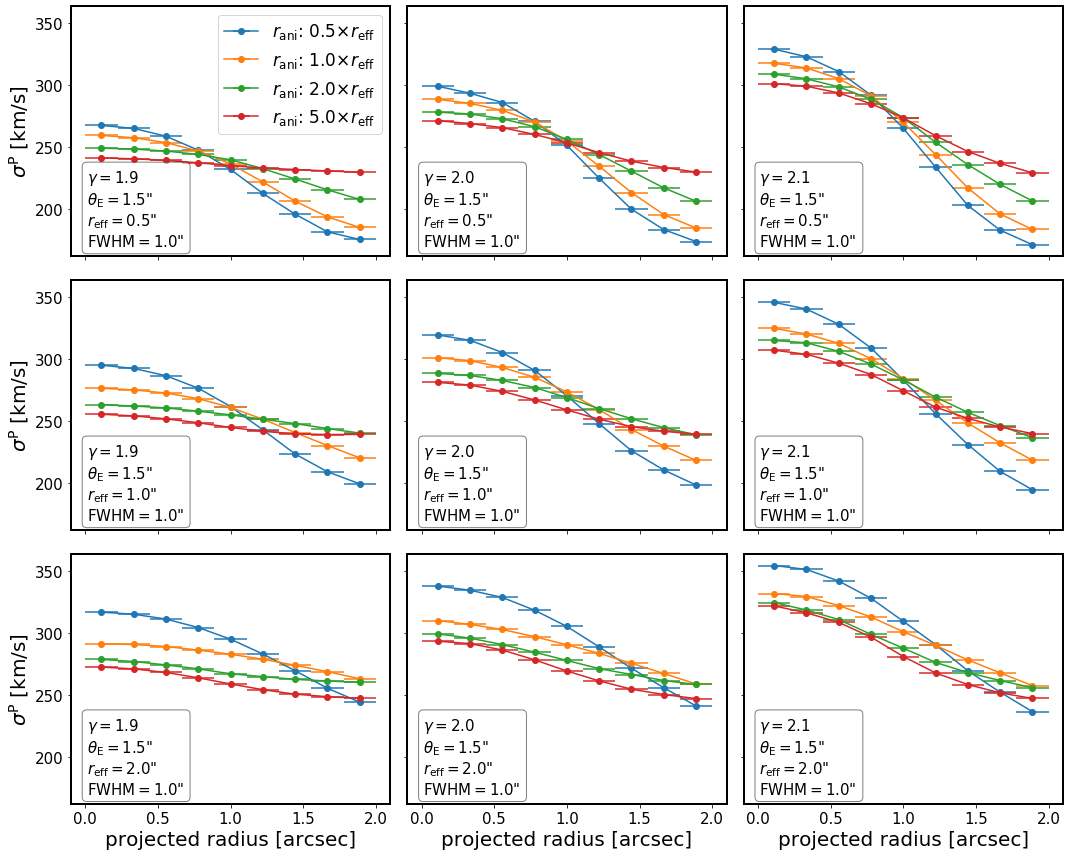

In [6]:
num_horizontal = len(gamma_list)
num_vertical = len(r_eff_list)
f, axes = plt.subplots(num_vertical, num_horizontal, figsize=(num_horizontal * 5, 4 * num_vertical), sharex=True, sharey=True)

for k, gamma in enumerate(gamma_list):
    for j, r_eff in enumerate(r_eff_list):
        ax = axes[j, k]
        for i in range(len(a_ani_list)):
            ax.errorbar(r_list, sigma_v_om[k][j][i], xerr=delta_r/2, fmt='o-', label=r'$r_{\rm ani}$: ' + str(a_ani_list[i]) +r'$\times r_{\rm eff}$')
            #ax.plot(r_list, sigma_v_om[k][j][i], label=r'$r_{\rm ani}$: ' + str(a_ani_list[i]) +r'$\times r_{\rm eff}$')
        if j == 0 and k == 0:
            ax.legend(fontsize=17)
        if j == num_horizontal - 1:
            ax.set_xlabel(r'projected radius [arcsec]', fontsize=20)
        if k == 0:
            ax.set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=20)
        # these are matplotlib.patch.Patch properties

        textstr = '\n'.join((
            r'$\gamma=%.1f$' % (gamma, ),
            r'${\theta_{\rm E}}=%.1f$"' % (theta_E, ),
            r'$r_{\rm eff}=%.1f$"' % (r_eff, ),
            r'FWHM$=%.1f$" ' % (psf_fwhm, )))
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.35, textstr, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', bbox=props)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/anisotropy_ifu_r_ani.pdf')
plt.show()

In [7]:
# constant anisotropy dependence
# r_ani dependence with OsipkovMerritt model
anisotropy_model = 'const'
kwargs_model = {'anisotropy_model': anisotropy_model,
               'mass_profile_list': lens_model_list,
               'light_profile_list': light_model_list}


galkin = Galkin(kwargs_model, kwargs_aperture, kwargs_psf, kwargs_cosmo, kwargs_numerics=kwargs_galkin_numerics, 
                 analytic_kinematics=False)


beta_ani_list = np.array([0., 0.1, 0.2, 0.3, 0.6, 1.])


sigma_v_beta = []

for k, gamma in enumerate(gamma_list):
    sigma_v_r_eff = []
    kwargs_mass = [{'theta_E': theta_E, 'gamma': gamma}, kwargs_core]
    for j, r_eff in enumerate(r_eff_list):
        sigma_v_r_ani_list = []
        kwargs_light = [{'Rs': 0.551 * r_eff, 'amp': 1}]

        for i, beta_ani in enumerate(beta_ani_list):
            kwargs_anisotropy = {'beta': beta_ani}
            sigma_v_ifu = galkin.dispersion_map(kwargs_mass, kwargs_light, kwargs_anisotropy, num_kin_sampling=1000, num_psf_sampling=100)
            sigma_v_r_ani_list.append(sigma_v_ifu)
        sigma_v_r_eff.append(sigma_v_r_ani_list)
    sigma_v_beta.append(sigma_v_r_eff)




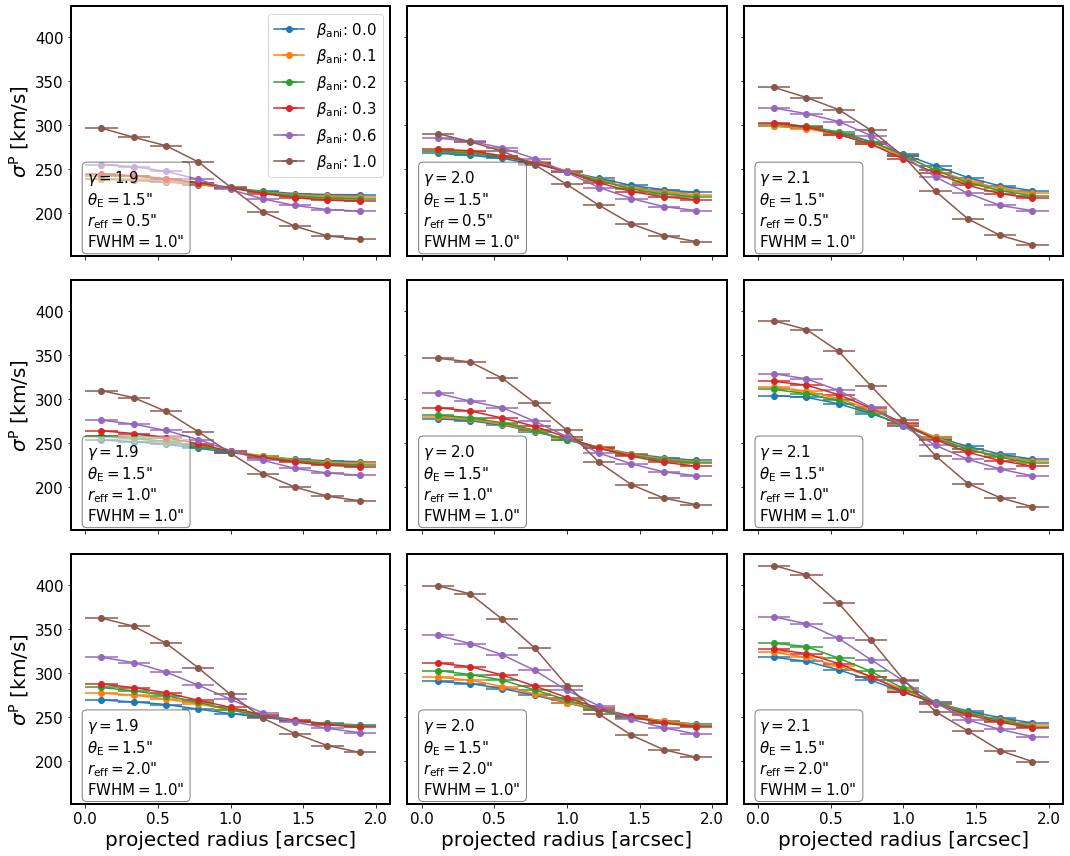

In [8]:
num_horizontal = len(gamma_list)
num_vertical = len(r_eff_list)
f, axes = plt.subplots(num_vertical, num_horizontal, figsize=(num_horizontal * 5, 4 * num_vertical), sharex=True, sharey=True)

for k, gamma in enumerate(gamma_list):
    for j, r_eff in enumerate(r_eff_list):
        ax = axes[j, k]
        for i in range(len(beta_ani_list)):
            ax.errorbar(r_list, sigma_v_beta[k][j][i], xerr=delta_r/2, fmt='o-', label=r'$\beta_{\rm ani}$: ' + str(beta_ani_list[i]))
            #ax.plot(r_list, sigma_v_beta[k][j][i], label=r'$\beta_{\rm ani}$: ' + str(beta_ani_list[i]))
        if j == 0 and k == 0:
            ax.legend(loc=1, fontsize=15)
        if j == num_horizontal - 1:
            ax.set_xlabel(r'projected radius [arcsec]', fontsize=20)
        if k == 0:
            ax.set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=20)
        # these are matplotlib.patch.Patch properties

        textstr = '\n'.join((
            r'$\gamma=%.1f$' % (gamma, ),
            r'${\theta_{\rm E}}=%.1f$"' % (theta_E, ),
            r'$r_{\rm eff}=%.1f$"' % (r_eff, ),
            r'FWHM$=%.1f$" ' % (psf_fwhm, )))
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.35, textstr, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', bbox=props)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/anisotropy_ifu_const.pdf')
plt.show()


In [9]:
anisotropy_model = 'OM'
kwargs_model = {'anisotropy_model': anisotropy_model,
               'mass_profile_list': lens_model_list,
               'light_profile_list': light_model_list}

psf_fwhm = .0
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

r_bins = np.linspace(0, 5, 10)
r_list = (r_bins[1:] + r_bins[:-1]) / 2
delta_r = r_bins[1] - r_bins[0]
kwargs_aperture = {'aperture_type': 'IFU_shells', 'r_bins': r_bins,  'center_ra': 0, 'center_dec': 0}

galkin = Galkin(kwargs_model, kwargs_aperture, kwargs_psf, kwargs_cosmo, kwargs_numerics=kwargs_galkin_numerics,
                 analytic_kinematics=False)

gamma = 2
r_ani = 1.
kwargs_anisotropy = {'r_ani': r_ani}

r_eff = 1.
kwargs_light = [{'Rs': 0.551 * r_eff, 'amp': 1}]

sigma_v_mst = []

lambda_int_list = [0.9, 0.95, 1, 1.05, 1.1]
r_core_list = [0.5, 1, 2, 5, 10]
for k, lambda_int in enumerate(lambda_int_list):
    sigma_v_r_core_list = []
    
    for i, r_core in enumerate(r_core_list):
        sigma0 = 1 - lambda_int
        kwargs_core = {'r_core': r_core, 'sigma0': sigma0, 'center_x': 0, 'center_y': 0}
        kwargs_mass = [{'theta_E': theta_E*lambda_int, 'gamma': gamma}, kwargs_core]
            
        sigma_v_ifu = galkin.dispersion_map(kwargs_mass, kwargs_light, kwargs_anisotropy, num_kin_sampling=1000, num_psf_sampling=100)
        sigma_v_r_core_list.append(sigma_v_ifu)

    sigma_v_mst.append(sigma_v_r_core_list)

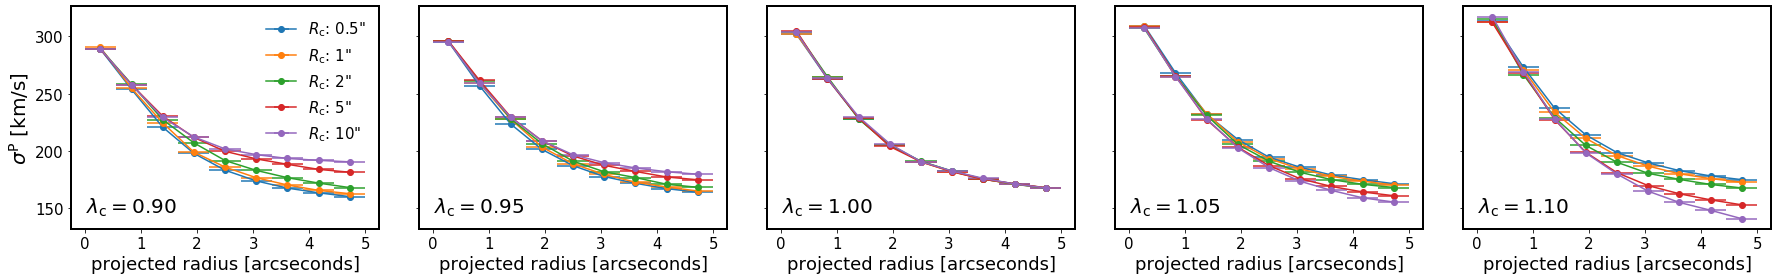

In [10]:
num_horizontal = len(lambda_int_list)
num_vertical = 1
f, axes = plt.subplots(num_vertical, num_horizontal, figsize=(num_horizontal * 5, 4 * num_vertical), sharex=True, sharey=True)

for k, lambda_int in enumerate(lambda_int_list):
        ax = axes[k]
        for i, r_core in enumerate(r_core_list):
            ax.errorbar(r_list, sigma_v_mst[k][i], xerr=delta_r/2, fmt='o-', label=r'$R_{\rm c}$: ' + str(r_core)+'"')
            #ax.plot(r_list, sigma_v_beta[k][j][i], label=r'$\beta_{\rm ani}$: ' + str(beta_ani_list[i]))
        #ax.legend(loc=1, fontsize=15, frameon=False)
        ax.set_xlabel(r'projected radius [arcseconds]', fontsize=18)
        #ax.set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=15)
        # these are matplotlib.patch.Patch properties

        textstr_lambda = '\n'.join((
            r'$\lambda_{\rm c}=%.2f$' % (lambda_int, ),))
        textstr = '\n'.join((
            r'${\theta_{\rm E}}=%.1f$"' % (theta_E, ),
            r'$r_{\rm eff}=%.1f$"' % (r_eff, ),
            r'FWHM$=%.1f$" ' % (psf_fwhm, )))
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        # place a text box in upper left in axes coords
        #ax.text(0.05, 0.3, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
        ax.text(0.05, 0.15, textstr_lambda, transform=ax.transAxes, fontsize=20,
                verticalalignment='top', bbox=None)
axes[0].legend(loc=1, fontsize=15, frameon=False)
axes[0].set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=20)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/anisotropy_ifu_mst.pdf')
plt.show()

5


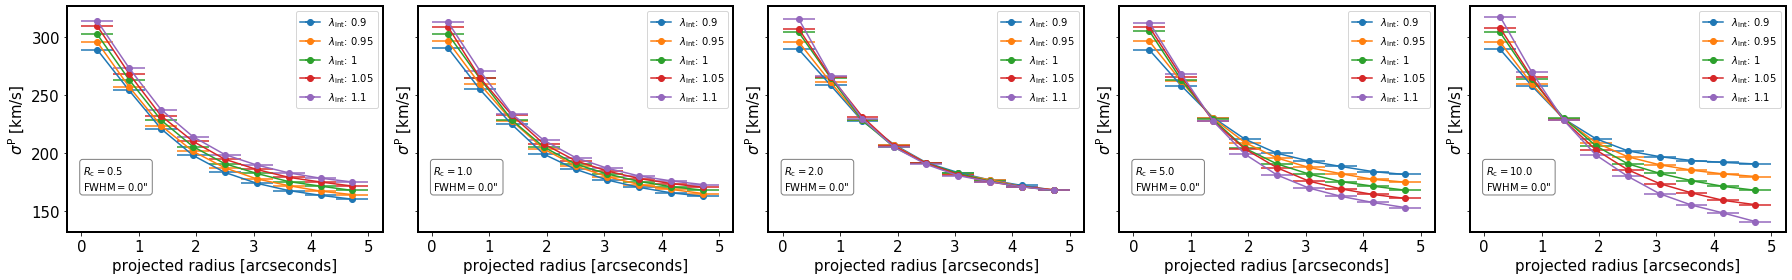

In [11]:
num_horizontal = len(r_core_list)
print(num_horizontal)
num_vertical = 1
f, axes = plt.subplots(num_vertical, num_horizontal, figsize=(num_horizontal * 5, 4 * num_vertical), sharex=True, sharey=True)

for i, r_core in enumerate(r_core_list):
        ax = axes[i]
        for k, lambda_int in enumerate(lambda_int_list):
            ax.errorbar(r_list, sigma_v_mst[k][i], xerr=delta_r/2, fmt='o-', label=r'$\lambda_{\rm int}$: ' + str(lambda_int))
            #ax.plot(r_list, sigma_v_beta[k][j][i], label=r'$\beta_{\rm ani}$: ' + str(beta_ani_list[i]))
        ax.legend(loc=1)
        ax.set_xlabel(r'projected radius [arcseconds]', fontsize=15)
        ax.set_ylabel(r'$\sigma^{\rm P}$ [km/s]', fontsize=15)
        # these are matplotlib.patch.Patch properties

        textstr = '\n'.join((
            r'$R_{\rm c}=%.1f$' % (r_core, ),
            r'FWHM$=%.1f$" ' % (psf_fwhm, )))
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.05, 0.3, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()